In [1]:
import numpy as np
import pandas as pd
import heapq
import concurrent.futures
import threading
import os 
import matplotlib.pyplot as plt

In [2]:
def threading_debug():
    print(f"""
    Process ID: {os.getpid()}
    Thread ID: {threading.get_ident()}
    Thread Name: {threading.current_thread().name}
    Is main thread: {threading.current_thread() is threading.main_thread()}
    """)

## 2.3.1

In [3]:
df_edges = pd.read_csv("edges.tsv", sep="\t")
df_nodes = pd.read_csv("nodes.tsv", sep="\t")
print(df_edges.head())
print(df_nodes.head())

          u           v       length            name
0  12885866    12885923    18.992015      Hlíðartorg
1  12885866  1573411414   653.666145  Reykjanesbraut
2  12885876  1660480490    35.437064      Flatahraun
3  12885876    12885952    16.131272         FH-Torg
4  12885922  2978379988  2587.067864  Reykjanesbraut
      osmid          x          y  primary
0  12885866 -21.937473  64.067271    False
1  12885876 -21.939951  64.076157     True
2  12885922 -22.087890  64.031977    False
3  12885923 -21.937852  64.067260    False
4  12885924 -21.938078  64.067047     True


## 2.3.2

In [4]:
# Input: 
#   -node: 
#   -edges: pandas dataframe of edges
#
# Returns: numpy array of the neighbors of node and distance
def get_neighbors(node_id, edges):
    neighbors = edges.query("u == {0}".format(node_id))
    return neighbors.to_numpy()


In [5]:
# Input: 
#   -start: id of starting node
#   -nodes: 
#   -edges: 
#
# Returns: 
def dijkstra(start, nodes=df_nodes, edges=df_edges):
    threading_debug()

    dist = dict.fromkeys(nodes['osmid'], float("infinity"))
    prev_edge = dict.fromkeys(nodes['osmid'], None)
    dist[start] = 0

    heap = [(0, start)]

    while heap:
        current_dist, u = heapq.heappop(heap)
        if current_dist > dist[u]:
            continue

        neighbors = get_neighbors(u, edges)
        for neighbor in neighbors:
            id, neighbor_id, neighbor_dist, name = neighbor

            new_dist = current_dist + neighbor_dist
            if new_dist < dist[neighbor_id]:
                dist[neighbor_id] = new_dist
                prev_edge[neighbor_id] = {
                    "u": id,
                    "v": neighbor_id,
                    "dist": neighbor_dist,
                    "name": name
                }
                heapq.heappush(heap, (new_dist, neighbor_id))
    return start, dist, prev_edge

In [6]:
# Input:
#   -V: Hleðslustöðvar
#
# Returns: numpy array af dictionaries {station, distances, edges}
def leit(V):
    def helper(future_item):
        future = future_item.result()
        return {
            "start_position": future[0],
            "distances": future[1],
            "edges": future[2]
        }

    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(dijkstra, node) for node in V['osmid'].tolist()]

    results = []
    for future_item in futures:
        results.append(helper(future_item))

    return np.array(results)

## 2.3.3

In [7]:
V = df_nodes.sample(n=5) # Charging stations
stations = leit(V)


    Process ID: 36136
    Thread ID: 35008
    Thread Name: ThreadPoolExecutor-0_0
    Is main thread: False
    

    Process ID: 36136
    Thread ID: 35720
    Thread Name: ThreadPoolExecutor-0_1
    Is main thread: False
    

    Process ID: 36136
    Thread ID: 19380
    Thread Name: ThreadPoolExecutor-0_2
    Is main thread: False
    

    Process ID: 36136
    Thread ID: 14560
    Thread Name: ThreadPoolExecutor-0_3
    Is main thread: False
    

    Process ID: 36136
    Thread ID: 35008
    Thread Name: ThreadPoolExecutor-0_0
    Is main thread: False
    


In [8]:
# Input: 
#   -paths: Dictinoary {start_position, distances, edges} 
#   -stations: List of stations.
# 
# Returns: 
#   -nearest_station_id: int 
#   -shortest_distance: float,
#   -shortest_path: List[edges]
def find_closest_station(paths, stations):
    start_position = paths["start_position"]
    distances = paths["distances"]
    backtracking_paths = paths["edges"]
    nearest_station_id = min(stations["osmid"].tolist(), key=lambda k: distances[k])

    shortest_distance = distances[nearest_station_id]

    shortest_path = []
    current_position = nearest_station_id
    while current_position != start_position:
        road = backtracking_paths[current_position]
        shortest_path.append(road)
        current_position = road["u"]

    return nearest_station_id, shortest_distance, shortest_path

In [9]:
stations = df_nodes.sample(n=5) # Charging stations
starting_positions = df_nodes.sample(n=5) # Starting positions

starting_position_paths = leit(starting_positions)


    Process ID: 36136
    Thread ID: 40868
    Thread Name: ThreadPoolExecutor-1_0
    Is main thread: False
    

    Process ID: 36136
    Thread ID: 33824
    Thread Name: ThreadPoolExecutor-1_1
    Is main thread: False
    

    Process ID: 36136
    Thread ID: 41676
    Thread Name: ThreadPoolExecutor-1_2
    Is main thread: False
    

    Process ID: 36136
    Thread ID: 34020
    Thread Name: ThreadPoolExecutor-1_3
    Is main thread: False
    

    Process ID: 36136
    Thread ID: 34020
    Thread Name: ThreadPoolExecutor-1_3
    Is main thread: False
    


In [10]:
navigations = []
for paths in starting_position_paths:
    navigations.append((find_closest_station(paths, stations)))

In [11]:
# Input: 
#   -node: Upphafsstaðsetning.
# 
# Returns: Listi af punktum

def find_route(path, edges=df_edges, nodes=df_nodes):
    osmid_of_path = list(dict.fromkeys(
        node for edge in path for node in (edge['u'], edge['v'])
    ))
    coordinates = [
        [nodes.loc[nodes['osmid'] == osmid, 'x'].values[0],
         nodes.loc[nodes['osmid'] == osmid, 'y'].values[0]]
        for osmid in osmid_of_path
    ]

    return np.array(coordinates)

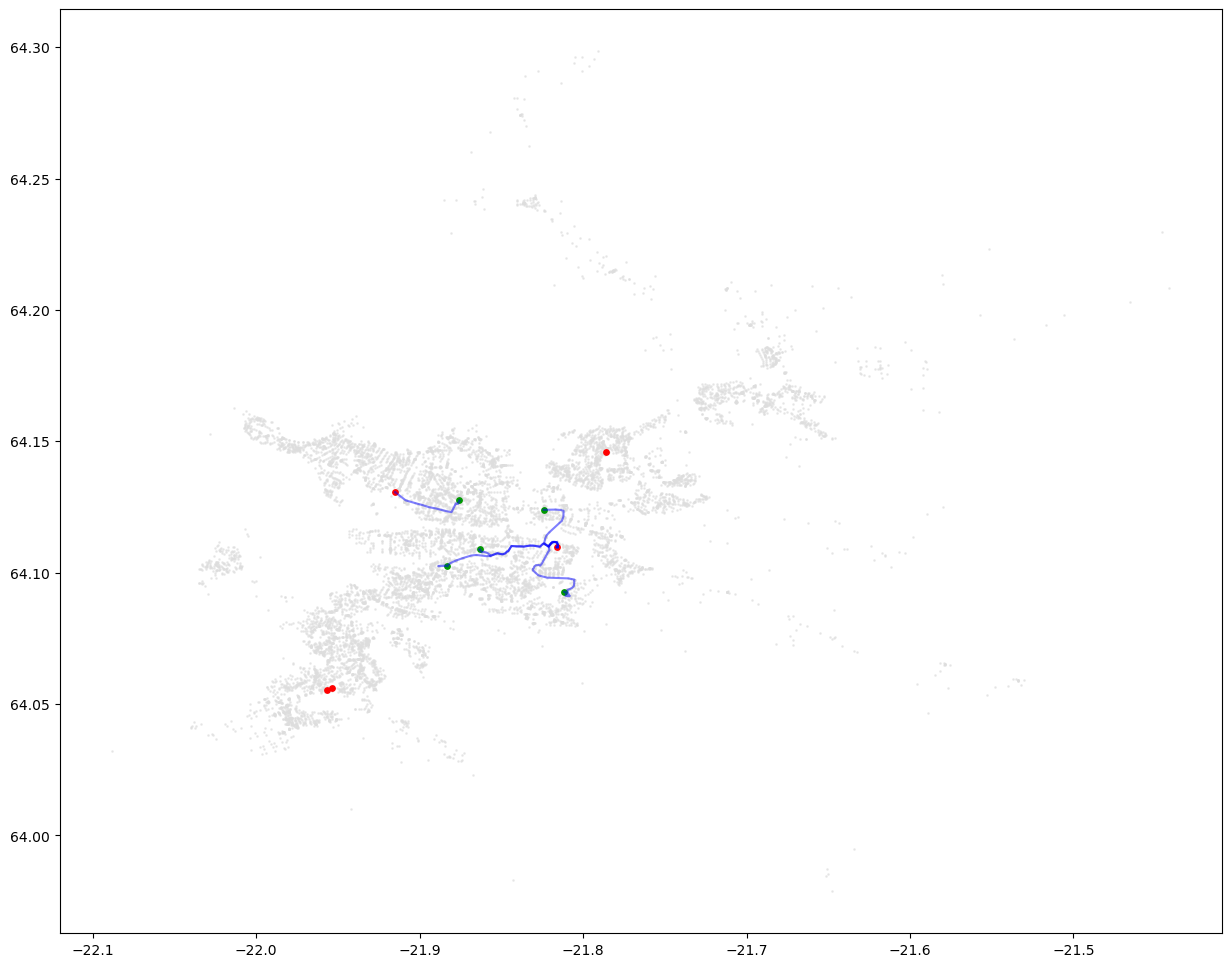

In [12]:
plt.figure(figsize=(15, 12))

for _,_,path in navigations: 
    route = find_route(path)
    plt.plot(route[:, 0],route[:, 1], c='blue', alpha=0.5)

plt.scatter(df_nodes['x'], df_nodes['y'], c='#dddddd', s=1, alpha=0.5)
plt.scatter(starting_positions['x'], starting_positions['y'], c='#009900', s=15, alpha=1)
plt.scatter(stations['x'], stations['y'], c='#ff0000', s=15, alpha=1)
plt.show()